In [1]:
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from sys import path
from os.path import exists
from imp import reload
from netCDF4 import Dataset
# path.insert(0, '/Users/H/WAVES/geo_data_group/')
path.insert(0, '/Users/owylie/MSci/')
import grid_set as gs

import Ekman_pumping as ep
import  Calculating_pumping as CP

Loaded a grid: /Users/owylie/MSci/Pathfinder_gs.npz


In [2]:
d = dt.datetime(2015,1,25)

m = ccrs.NorthPolarStereo()

#### setup plotting grid - Gplot
f = plt.figure()
Gplot= gs.grid_set(m)

ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
### make a new grid
Gplot.set_grid_mn(30,30,ax)
Gplot.get_grid_info(av_ang=False)
plt.close()

Got a grid res =  30  x  30
Grid distances calculated:  188686.82035191165  x  188898.93509145544
Angles calculated


### PATHFINDER

In [3]:
#### for ice drift
### find it here:
### https://nsidc.org/data/NSIDC-0116/versions/4
### one file per year, put them all in one folder
class Pathfinder():
    """
    forcing class for the budget
    lets the forcing load efficiently
    
    """
    def __init__(self,ppath,grid=False):
        self.name = 'Pathfinder'
        self.path = ppath
        self.vyear_load = 0
        self.vels_loaded = False
        if type(grid) == bool:
            self.check_grid = False
        else:
            self.check_grid = True
            self.grid = grid
        
    def get_dates(self,time_start,time_end):
        """
        returns the all encompassing date list for use with the forcing object
        """
        dates =[]
        d0 = dt.datetime(1970,1,1)
        n_yrs = (time_end.year - time_start.year)+1
        for y in range(n_yrs):
            yu = time_start.year + y
            f_name = 'icemotion_daily_nh_25km_'+str(yu)+'0101_'+str(yu)+'1231_v4.1.nc'
            if exists(self.path+f_name):
                ### converting days_since_1970-01-01 to datetimes
                f_nc = Dataset(self.path+f_name)
                [dates.append(d0 + relativedelta(days = d))
                     for d in f_nc['time'][:]]
                f_nc.close()
        self.dates = dates
        print(self.name+' Found '+str(np.shape(dates)[0])+' dates')


    # next function will take a list of dates and return an appropriately orientated arrays
    # give a 
    def get_vels(self,dates_u,verbos=False):
        d0 = dt.datetime(1970,1,1)
        # does dates_u cover one year or more
        if (dates_u[-1].year -dates_u[0].year) == 0:
            # one year, one file
            yu = dates_u[0].year
            if ((self.vyear_load != yu) or (not self.vels_loaded)):
                print('loading new year of data: '+str(yu))
                f_name = 'icemotion_daily_nh_25km_'+str(yu)+'0101_'+str(yu)+'1231_v4.1.nc'
                f_nc = Dataset(self.path+f_name)
        #         print(p0,p1)
                self.u = f_nc['u'][:]
                self.v = f_nc['v'][:]
                self.u[self.u.mask] = np.nan
                self.v[self.v.mask] = np.nan
                f_nc.close()
                self.vyear_load = yu
                self.vels_loaded= True
            p0 = dates_u[ 0].timetuple().tm_yday -1
            p1 = dates_u[-1].timetuple().tm_yday 
            datau = self.u[p0:p1,:,:].transpose((0,2,1))/100
            datav = self.v[p0:p1,:,:].transpose((0,2,1))/100
            if self.check_grid:
                for n in range(np.shape(datau)[0]):
                    datau[n][self.grid.lats>88] = np.nanmean
                    datav[n][self.grid.lats>88] = np.nanmean
            return datau,datav


In [4]:
#grid
GPathfinder = gs.grid_set(m)
GPathfinder.load_grid('/Users/owylie/MSci/Pathfinder_gs.npz')

#vels
DRIFT = Pathfinder('/Users/owylie/MSci/Pathfinder/')

# regrid to plot
GPathfinder2Gplot = gs.Gs2Gs(GPathfinder,Gplot,vectors=True)

###gridding on pathfinder so doesnt need regridding
GPathfinder2GPathfinder = gs.Gs2Gs(GPathfinder,GPathfinder,vectors=True)

Loaded a grid: /Users/owylie/MSci/Pathfinder_gs.npz


### ERA5 DAILY

In [5]:
#ERA5 10m MONTHLY winds
class ERA5_days():
    """
    forcing class for the budget
    lets the forcing load efficiently
   
    """
    def __init__(self,ppath):
        self.name = 'ERA5_Daily_Winds'
        self.path = ppath
        self.file = self.path+'2020_all.nc' 
        self.f_nc = Dataset(self.file)
       
    def get_dates(self,day_wanted):
        """
        returns the all encompassing date list for use with the forcing object
        """
        d0 = dt.datetime(2020,1,1) #first month of dataset
        self.file = self.path+'2020_all.nc' 
        self.f_nc = Dataset(self.file)
        self.days = self.f_nc.variables['time'][:]
        #this makes sure we have the month that is asked for:
        self.days_all = [d0 + relativedelta(days=d) for d in range(len(self.days))]
        self.times = [i for i in self.days_all if i >= day_wanted and i < day_wanted+relativedelta(days=1)] 
        #print(self.name+' Found '+str(np.shape(self.times)[0])+' data points')
        
        
    def get_vels(self):
        """
        NOTE: gives the velocities of the month specified in get_dates above, NOT in get_vels as usual
        """
        #finding the index:
        n = 0
        for n in range(0,len(self.days)):
            if self.days_all[n] in self.times:
                idx = n

        u10 = self.f_nc.variables['u10'][idx]
        v10 = self.f_nc.variables['v10'][idx]
        
        return u10,v10

In [6]:
Wind = ERA5_days('/Users/owylie/MSci/ERA5/')

In [7]:
Wind.get_dates(dt.datetime(2020,3,2))

In [8]:
#grid
lonE = Wind.f_nc.variables['longitude'][:].data
latE = Wind.f_nc.variables['latitude'][:].data
lon,lat = np.meshgrid(lonE,latE)
#masks out the lower latitudes to make it all a bit more efficient
lon[lat<60] = np.nan
lat[lat<60] = np.nan

GE = gs.grid_set(m)
GE.set_grid_lon_lat(lon,lat)
GE.blank_grid_info()
GE.ang_c[:] = 1.0

GE2Gplot = gs.Gs2Gs(GE,Gplot,vectors=True,NaN_avoid=True) 
GE2GPathfinder = gs.Gs2Gs(GE,GPathfinder,vectors=True,NaN_avoid=True)

Got a grid res =  121  x  1440
Note that all grid info is in nx x ny grids, whilst data is in nx x ny
Gs2Gs bad point avoidance found  0
Gs2Gs bad point avoidance found  0


### NSIDC 

In [9]:
class NSIDC_nt():
    """
    forcing class for the budget
    lets the forcing load efficiently
    
    """
    def __init__(self,ppath):
        self.name = 'NSIDC_n'
        self.path = ppath
# next function will take a list of dates and return an appropriately orientated arrays
# give a 
    def get_aice(self,dates_u,verbos=False):
        # does dates_u cover one year or more
        #daily files
        dimY = 304
        dimX = 448
        d_no = np.shape(dates_u)[0]
        data =  np.empty([d_no, dimX, dimY])
        for n,d in enumerate(dates_u):
            #if d>=dt.datetime(2020,11,1):
                #infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f18_nrt_n.bin"
            #else:
            infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f17_v1.1_n.bin"
            with open(infile, 'rb') as fr:
                hdr = fr.read(300)
                ice = np.fromfile(fr, dtype=np.uint8)

            ice = ice.reshape(dimX,dimY)
            ice = np.flipud(ice)
            data[n] = ice / 250.
        data[data>1.0] = np.nan
        return data

    def get_dates(self,time_start,time_end):
        # does dates_u cover one year or more
        #daily files
        dates_u = []
        d_no = (time_end-time_start).days +3 
        # make sure we get the bracket points
        for dn in range(d_no):
            d = time_start+ relativedelta(days = dn - 1)
            #if d>=dt.datetime(2020,11,1):
            #    infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f18_nrt_n.bin"
            #else:
#             if d.year>2019:
            infile = self.path+d.strftime('/%Y/')+"nt_"+d.strftime('%Y%m%d')+"_f17_v1.1_n.bin"
            # check infile exists 
            if exists(infile):
                dates_u.append(d)
            #if it does append dates_u
        self.dates= dates_u
        print(self.name+' Found '+str(np.shape(dates_u)[0])+' dates')


In [10]:
#grid
GIC = gs.grid_set(m)
GIC.load_grid('/Users/owylie/MSci/NSIDC_gs.npz')

#values
IC = NSIDC_nt('/Users/owylie/MSci/NSIDC_nt')

#regrid to pathfinder
GIC2GPathfinder = gs.Gs2Gs(GIC,GPathfinder,vectors=False)

Loaded a grid: /Users/owylie/MSci/NSIDC_gs.npz


### CPOM GEOS

In [11]:
#### for geostropic vels
### find it here:
### http://www.cpom.ucl.ac.uk/dynamic_topography/
### one file for all of it
class CPOM_geo():
    """
    forcing class for the budget
    lets the forcing load efficiently
    """
    def __init__(self,ppath,grid=False):
        self.name = 'CPOM_Geostrophic_Currents'
        self.path = ppath
        
    def get_dates(self,time_start,time_end):
        """
        returns the all encompassing date list for use with the forcing object
        """
        d0 = dt.datetime(2000,1,1)
        self.file = self.path+'Full_DOT_data_Arco.nc'
        self.f_nc = Dataset(self.file)
        self.m = self.f_nc.dimensions['x'].size
        self.n = self.f_nc.dimensions['y'].size
        self.time_vec = self.f_nc.variables['time'][:]
        self.dates_all = [d0+relativedelta(days=t+14) for t in self.time_vec]
        self.dates = [ d for d in self.dates_all if d >= time_start and d <= time_end]
        print(self.name+' Found '+str(np.shape(self.dates)[0])+' dates')

    # next function will take a list of dates and return an appropriately orientated arrays
    # give a 
    def get_vels(self,dates_u,verbos=False):
        d0 = dt.datetime(2000,1,1)
        ### find the indices
        idx = [np.argwhere(np.array([d == du for d  in self.dates_all] ))[0,0] 
                                             for du in dates_u]
        ### little bit of checking
        if verbos:
            for i,du in zip(idx,dates_u):
                print(du.strftime('%Y%m%d'),i)
#                 dcheck = dt.datetime(1,1,1)
#                 dcheck = dcheck+relativedelta(days=self.time_vec[i])
#                 dcheck = dcheck+relativedelta(years=-1)
#                 print(du.strftime('%Y%m%d-')+dcheck.strftime('%Y%m%d'))
        datau =  self.f_nc.variables['Geo_surf_current_x'][idx]
        datav = -self.f_nc.variables['Geo_surf_current_y'][idx]
        return datau,datav

    def get_vels_daily(self,dates_u,verbos=False):
        nt = len(dates_u)
        u_out = np.empty([nt,self.m,self.n])
        v_out = np.empty([nt,self.m,self.n])
        time_w = relativedelta(days=1)
        for nu,time_u in enumerate(dates_u):
            dates_r = []
            window = False
            for n,d in enumerate(self.dates):
                # go along list checking if we get passed time_u

                if ((time_u - d ).days -1 < 0) and not window:
                    window = True
        #             print(d.strftime('%Y%m%d'))
                    # we also need the 'bracket slices'
                    # either side of the date in interest
                    # so to interpolate when there isn't any
                    if n > 0: dates_r.append(dprev)  

                if window: dates_r.append(d)    

                if (time_u + time_w - d ).days -1 < 0:
        #             print(d.strftime('%Y%m%d'))
                    window = False
                    break
                dprev = d
            if window:
                dates_r.append([])
            if len(dates_r)==1:
                dnew = [[],dates_r[0],[]]
                dates_r = dnew
            if verbos:
                print([d.strftime('%Y%m%d') for d in dates_r if type(d)!=list])
            w0 = 0.0
            w1 = 0.0
            load_I = False
            if np.shape(dates_r)[0]>2:
                # we don't need the end point so load from
                # between
                d_load = dates_r[1:-1]
            elif ((time_u - dates_r[0]).days == 0):
                # if we're doing single days and our day hits the first point exactly do that
                d_load = [dates_r[0]]
            elif ((time_u - dates_r[1]).days == 0):
                d_load = [dates_r[1]]

            else: 
                # then we're doing some sort of days interp so use the endpoints
                load_I = True
                # find weights depending on range we're interested in
                dw = time_w.days
                dgap = (dates_r[1]- dates_r[0]).days
                dgap0 = (time_u- dates_r[0]).days
                w0 = np.sum([1-n/dgap 
                             for n in range(dgap0,dgap0+dw)])/dw
                w1 = np.sum([n/dgap 
                             for n in range(dgap0,dgap0+dw)])/dw
                d_load = dates_r
            ### now get monthlies
            u_in,v_in = self.get_vels(d_load,verbos=verbos)
            if load_I:
                u_out[nu] = (u_in[0]*w0 + u_in[1]*w1)
                v_out[nu] = (v_in[0]*w0 + v_in[1]*w1)
                if verbos: print("interpolating "+self.name+" velocity") 
            else:
                u_out[nu] = (np.nanmean(u_in,axis=0))
                v_out[nu] = (np.nanmean(v_in,axis=0))
                sno = np.shape(d_load)[0]
                if verbos: print("loading "+self.name+" velocity, "+str(sno)+" slices")
            if verbos: print("mean vel: ",'{:.3}'.format(np.nanmean(np.hypot(u_out,v_out))))
        return u_out,v_out


In [12]:
#grid
GCPOM = gs.grid_set(m)
GCPOM.load_grid('/Users/owylie/MSci/PS_20km_gs2021.npz')

#vels
GEO = CPOM_geo('/Users/owylie/MSci/CPOM_geo/')
GEO.get_dates(dt.datetime(2010,1,1),dt.datetime(2021,1,31))

#regrid to plot
GCPOM2Gplot = gs.Gs2Gs(GCPOM,Gplot,vectors=True)

#regrid to pathfinder
GCPOM2GPathfinder = gs.Gs2Gs(GCPOM,GPathfinder,vectors=True)

Loaded a grid: /Users/owylie/MSci/PS_20km_gs2021.npz
CPOM_Geostrophic_Currents Found 120 dates


In [13]:
GEO.get_dates(dt.datetime(2010,1,1),dt.datetime(2021,1,31))

CPOM_Geostrophic_Currents Found 120 dates


### EKMAN CALC

In [14]:
jan_ek = np.zeros(31)
jan_wind = np.zeros(31)
jan_ice = np.zeros(31)
jan_geo = np.zeros(31)
jan_ocean = np.zeros(31)
jan_pumping = np.zeros(31)
jan_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,1,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    jan_ek[i-1] = ek_av_speed
    jan_wind[i-1] = wind_av_speed
    jan_ice[i-1] = ice_av_speed
    jan_geo[i-1] = geo_av_speed
    jan_ocean[i-1] = ocean_av_speed
    jan_pumping[i-1] = pumping_av
    jan_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

loading new year of data: 2020
2020-01-01 00:00:00 calculation complete
2020-01-02 00:00:00 calculation complete
2020-01-03 00:00:00 calculation complete
2020-01-04 00:00:00 calculation complete
2020-01-05 00:00:00 calculation complete
2020-01-06 00:00:00 calculation complete
2020-01-07 00:00:00 calculation complete
2020-01-08 00:00:00 calculation complete
2020-01-09 00:00:00 calculation complete
2020-01-10 00:00:00 calculation complete
2020-01-11 00:00:00 calculation complete
2020-01-12 00:00:00 calculation complete
2020-01-13 00:00:00 calculation complete
2020-01-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-01-15 00:00:00 calculation complete
2020-01-16 00:00:00 calculation complete
2020-01-17 00:00:00 calculation complete
2020-01-18 00:00:00 calculation complete
2020-01-19 00:00:00 calculation complete
2020-01-20 00:00:00 calculation complete
2020-01-21 00:00:00 calculation complete
2020-01-22 00:00:00 calculation complete
2020-01-23 00:00:00 calculation complete
2020-01-24 00:00:00 calculation complete
2020-01-25 00:00:00 calculation complete
2020-01-26 00:00:00 calculation complete
2020-01-27 00:00:00 calculation complete
2020-01-28 00:00:00 calculation complete
2020-01-29 00:00:00 calculation complete
2020-01-30 00:00:00 calculation complete
2020-01-31 00:00:00 calculation complete


In [15]:
feb_ek = np.zeros(29)
feb_wind = np.zeros(29)
feb_ice = np.zeros(29)
feb_geo = np.zeros(29)
feb_ocean = np.zeros(29)
feb_pumping = np.zeros(29)
feb_diff = np.zeros(29)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,30):
    d = dt.datetime(2020,2,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    feb_ek[i-1] = ek_av_speed
    feb_wind[i-1] = wind_av_speed
    feb_ice[i-1] = ice_av_speed
    feb_geo[i-1] = geo_av_speed
    feb_ocean[i-1] = ocean_av_speed
    feb_pumping[i-1] = pumping_av
    feb_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-02-01 00:00:00 calculation complete
2020-02-02 00:00:00 calculation complete
2020-02-03 00:00:00 calculation complete
2020-02-04 00:00:00 calculation complete
2020-02-05 00:00:00 calculation complete
2020-02-06 00:00:00 calculation complete
2020-02-07 00:00:00 calculation complete
2020-02-08 00:00:00 calculation complete
2020-02-09 00:00:00 calculation complete
2020-02-10 00:00:00 calculation complete
2020-02-11 00:00:00 calculation complete
2020-02-12 00:00:00 calculation complete
2020-02-13 00:00:00 calculation complete
2020-02-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-02-15 00:00:00 calculation complete
2020-02-16 00:00:00 calculation complete
2020-02-17 00:00:00 calculation complete
2020-02-18 00:00:00 calculation complete
2020-02-19 00:00:00 calculation complete
2020-02-20 00:00:00 calculation complete
2020-02-21 00:00:00 calculation complete
2020-02-22 00:00:00 calculation complete
2020-02-23 00:00:00 calculation complete
2020-02-24 00:00:00 calculation complete
2020-02-25 00:00:00 calculation complete
2020-02-26 00:00:00 calculation complete
2020-02-27 00:00:00 calculation complete
2020-02-28 00:00:00 calculation complete
2020-02-29 00:00:00 calculation complete


In [16]:
mar_ek = np.zeros(31)
mar_wind = np.zeros(31)
mar_ice = np.zeros(31)
mar_geo = np.zeros(31)
mar_ocean = np.zeros(31)
mar_pumping = np.zeros(31)
mar_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,3,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    mar_ek[i-1] = ek_av_speed
    mar_wind[i-1] = wind_av_speed
    mar_ice[i-1] = ice_av_speed
    mar_geo[i-1] = geo_av_speed
    mar_ocean[i-1] = ocean_av_speed
    mar_pumping[i-1] = pumping_av
    mar_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-03-01 00:00:00 calculation complete
2020-03-02 00:00:00 calculation complete
2020-03-03 00:00:00 calculation complete
2020-03-04 00:00:00 calculation complete
2020-03-05 00:00:00 calculation complete
2020-03-06 00:00:00 calculation complete
2020-03-07 00:00:00 calculation complete
2020-03-08 00:00:00 calculation complete
2020-03-09 00:00:00 calculation complete
2020-03-10 00:00:00 calculation complete
2020-03-11 00:00:00 calculation complete
2020-03-12 00:00:00 calculation complete
2020-03-13 00:00:00 calculation complete
2020-03-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-03-15 00:00:00 calculation complete
2020-03-16 00:00:00 calculation complete
2020-03-17 00:00:00 calculation complete
2020-03-18 00:00:00 calculation complete
2020-03-19 00:00:00 calculation complete
2020-03-20 00:00:00 calculation complete
2020-03-21 00:00:00 calculation complete
2020-03-22 00:00:00 calculation complete
2020-03-23 00:00:00 calculation complete
2020-03-24 00:00:00 calculation complete
2020-03-25 00:00:00 calculation complete
2020-03-26 00:00:00 calculation complete
2020-03-27 00:00:00 calculation complete
2020-03-28 00:00:00 calculation complete
2020-03-29 00:00:00 calculation complete
2020-03-30 00:00:00 calculation complete
2020-03-31 00:00:00 calculation complete


In [17]:
apr_ek = np.zeros(30)
apr_wind = np.zeros(30)
apr_ice = np.zeros(30)
apr_geo = np.zeros(30)
apr_ocean = np.zeros(30)
apr_pumping = np.zeros(30)
apr_diff = np.zeros(30)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,31):
    d = dt.datetime(2020,4,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    apr_ek[i-1] = ek_av_speed
    apr_wind[i-1] = wind_av_speed
    apr_ice[i-1] = ice_av_speed
    apr_geo[i-1] = geo_av_speed
    apr_ocean[i-1] = ocean_av_speed
    apr_pumping[i-1] = pumping_av
    apr_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-04-01 00:00:00 calculation complete
2020-04-02 00:00:00 calculation complete
2020-04-03 00:00:00 calculation complete
2020-04-04 00:00:00 calculation complete
2020-04-05 00:00:00 calculation complete
2020-04-06 00:00:00 calculation complete
2020-04-07 00:00:00 calculation complete
2020-04-08 00:00:00 calculation complete
2020-04-09 00:00:00 calculation complete
2020-04-10 00:00:00 calculation complete
2020-04-11 00:00:00 calculation complete
2020-04-12 00:00:00 calculation complete
2020-04-13 00:00:00 calculation complete
2020-04-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-04-15 00:00:00 calculation complete
2020-04-16 00:00:00 calculation complete
2020-04-17 00:00:00 calculation complete
2020-04-18 00:00:00 calculation complete
2020-04-19 00:00:00 calculation complete
2020-04-20 00:00:00 calculation complete
2020-04-21 00:00:00 calculation complete
2020-04-22 00:00:00 calculation complete
2020-04-23 00:00:00 calculation complete
2020-04-24 00:00:00 calculation complete
2020-04-25 00:00:00 calculation complete
2020-04-26 00:00:00 calculation complete
2020-04-27 00:00:00 calculation complete
2020-04-28 00:00:00 calculation complete
2020-04-29 00:00:00 calculation complete
2020-04-30 00:00:00 calculation complete


In [18]:
may_ek = np.zeros(31)
may_wind = np.zeros(31)
may_ice = np.zeros(31)
may_geo = np.zeros(31)
may_ocean = np.zeros(31)
may_pumping = np.zeros(31)
may_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,5,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    may_ek[i-1] = ek_av_speed
    may_wind[i-1] = wind_av_speed
    may_ice[i-1] = ice_av_speed
    may_geo[i-1] = geo_av_speed
    may_ocean[i-1] = ocean_av_speed
    may_pumping[i-1] = pumping_av
    may_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-05-01 00:00:00 calculation complete
2020-05-02 00:00:00 calculation complete
2020-05-03 00:00:00 calculation complete
2020-05-04 00:00:00 calculation complete
2020-05-05 00:00:00 calculation complete
2020-05-06 00:00:00 calculation complete
2020-05-07 00:00:00 calculation complete
2020-05-08 00:00:00 calculation complete
2020-05-09 00:00:00 calculation complete
2020-05-10 00:00:00 calculation complete
2020-05-11 00:00:00 calculation complete
2020-05-12 00:00:00 calculation complete
2020-05-13 00:00:00 calculation complete
2020-05-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-05-15 00:00:00 calculation complete
2020-05-16 00:00:00 calculation complete
2020-05-17 00:00:00 calculation complete
2020-05-18 00:00:00 calculation complete
2020-05-19 00:00:00 calculation complete
2020-05-20 00:00:00 calculation complete
2020-05-21 00:00:00 calculation complete
2020-05-22 00:00:00 calculation complete
2020-05-23 00:00:00 calculation complete
2020-05-24 00:00:00 calculation complete
2020-05-25 00:00:00 calculation complete
2020-05-26 00:00:00 calculation complete
2020-05-27 00:00:00 calculation complete
2020-05-28 00:00:00 calculation complete
2020-05-29 00:00:00 calculation complete
2020-05-30 00:00:00 calculation complete
2020-05-31 00:00:00 calculation complete


In [19]:
jun_ek = np.zeros(30)
jun_wind = np.zeros(30)
jun_ice = np.zeros(30)
jun_geo = np.zeros(30)
jun_ocean = np.zeros(30)
jun_pumping = np.zeros(30)
jun_diff = np.zeros(30)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,31):
    d = dt.datetime(2020,6,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    jun_ek[i-1] = ek_av_speed
    jun_wind[i-1] = wind_av_speed
    jun_ice[i-1] = ice_av_speed
    jun_geo[i-1] = geo_av_speed
    jun_ocean[i-1] = ocean_av_speed
    jun_pumping[i-1] = pumping_av
    jun_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-06-01 00:00:00 calculation complete
2020-06-02 00:00:00 calculation complete
2020-06-03 00:00:00 calculation complete
2020-06-04 00:00:00 calculation complete
2020-06-05 00:00:00 calculation complete
2020-06-06 00:00:00 calculation complete
2020-06-07 00:00:00 calculation complete
2020-06-08 00:00:00 calculation complete
2020-06-09 00:00:00 calculation complete
2020-06-10 00:00:00 calculation complete
2020-06-11 00:00:00 calculation complete
2020-06-12 00:00:00 calculation complete
2020-06-13 00:00:00 calculation complete
2020-06-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-06-15 00:00:00 calculation complete
2020-06-16 00:00:00 calculation complete
2020-06-17 00:00:00 calculation complete
2020-06-18 00:00:00 calculation complete
2020-06-19 00:00:00 calculation complete
2020-06-20 00:00:00 calculation complete
2020-06-21 00:00:00 calculation complete
2020-06-22 00:00:00 calculation complete
2020-06-23 00:00:00 calculation complete
2020-06-24 00:00:00 calculation complete
2020-06-25 00:00:00 calculation complete
2020-06-26 00:00:00 calculation complete
2020-06-27 00:00:00 calculation complete
2020-06-28 00:00:00 calculation complete
2020-06-29 00:00:00 calculation complete
2020-06-30 00:00:00 calculation complete


In [20]:
jul_ek = np.zeros(31)
jul_wind = np.zeros(31)
jul_ice = np.zeros(31)
jul_geo = np.zeros(31)
jul_ocean = np.zeros(31)
jul_pumping = np.zeros(31)
jul_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,7,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    jul_ek[i-1] = ek_av_speed
    jul_wind[i-1] = wind_av_speed
    jul_ice[i-1] = ice_av_speed
    jul_geo[i-1] = geo_av_speed
    jul_ocean[i-1] = ocean_av_speed
    jul_pumping[i-1] = pumping_av
    jul_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-07-01 00:00:00 calculation complete
2020-07-02 00:00:00 calculation complete
2020-07-03 00:00:00 calculation complete
2020-07-04 00:00:00 calculation complete
2020-07-05 00:00:00 calculation complete
2020-07-06 00:00:00 calculation complete
2020-07-07 00:00:00 calculation complete
2020-07-08 00:00:00 calculation complete
2020-07-09 00:00:00 calculation complete
2020-07-10 00:00:00 calculation complete
2020-07-11 00:00:00 calculation complete
2020-07-12 00:00:00 calculation complete
2020-07-13 00:00:00 calculation complete
2020-07-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-07-15 00:00:00 calculation complete
2020-07-16 00:00:00 calculation complete
2020-07-17 00:00:00 calculation complete
2020-07-18 00:00:00 calculation complete
2020-07-19 00:00:00 calculation complete
2020-07-20 00:00:00 calculation complete
2020-07-21 00:00:00 calculation complete
2020-07-22 00:00:00 calculation complete
2020-07-23 00:00:00 calculation complete
2020-07-24 00:00:00 calculation complete
2020-07-25 00:00:00 calculation complete
2020-07-26 00:00:00 calculation complete
2020-07-27 00:00:00 calculation complete
2020-07-28 00:00:00 calculation complete
2020-07-29 00:00:00 calculation complete
2020-07-30 00:00:00 calculation complete
2020-07-31 00:00:00 calculation complete


In [21]:
aug_ek = np.zeros(31)
aug_wind = np.zeros(31)
aug_ice = np.zeros(31)
aug_geo = np.zeros(31)
aug_ocean = np.zeros(31)
aug_pumping = np.zeros(31)
aug_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,8,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    aug_ek[i-1] = ek_av_speed
    aug_wind[i-1] = wind_av_speed
    aug_ice[i-1] = ice_av_speed
    aug_geo[i-1] = geo_av_speed
    aug_ocean[i-1] = ocean_av_speed
    aug_pumping[i-1] = pumping_av
    aug_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-08-01 00:00:00 calculation complete
2020-08-02 00:00:00 calculation complete
2020-08-03 00:00:00 calculation complete
2020-08-04 00:00:00 calculation complete
2020-08-05 00:00:00 calculation complete
2020-08-06 00:00:00 calculation complete
2020-08-07 00:00:00 calculation complete
2020-08-08 00:00:00 calculation complete
2020-08-09 00:00:00 calculation complete
2020-08-10 00:00:00 calculation complete
2020-08-11 00:00:00 calculation complete
2020-08-12 00:00:00 calculation complete
2020-08-13 00:00:00 calculation complete
2020-08-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-08-15 00:00:00 calculation complete
2020-08-16 00:00:00 calculation complete
2020-08-17 00:00:00 calculation complete
2020-08-18 00:00:00 calculation complete
2020-08-19 00:00:00 calculation complete
2020-08-20 00:00:00 calculation complete
2020-08-21 00:00:00 calculation complete
2020-08-22 00:00:00 calculation complete
2020-08-23 00:00:00 calculation complete
2020-08-24 00:00:00 calculation complete
2020-08-25 00:00:00 calculation complete
2020-08-26 00:00:00 calculation complete
2020-08-27 00:00:00 calculation complete
2020-08-28 00:00:00 calculation complete
2020-08-29 00:00:00 calculation complete
2020-08-30 00:00:00 calculation complete
2020-08-31 00:00:00 calculation complete


In [22]:
sep_ek = np.zeros(30)
sep_wind = np.zeros(30)
sep_ice = np.zeros(30)
sep_geo = np.zeros(30)
sep_ocean = np.zeros(30)
sep_pumping = np.zeros(30)
sep_diff = np.zeros(30)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,31):
    d = dt.datetime(2020,9,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    sep_ek[i-1] = ek_av_speed
    sep_wind[i-1] = wind_av_speed
    sep_ice[i-1] = ice_av_speed
    sep_geo[i-1] = geo_av_speed
    sep_ocean[i-1] = ocean_av_speed
    sep_pumping[i-1] = pumping_av
    sep_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-09-01 00:00:00 calculation complete
2020-09-02 00:00:00 calculation complete
2020-09-03 00:00:00 calculation complete
2020-09-04 00:00:00 calculation complete
2020-09-05 00:00:00 calculation complete
2020-09-06 00:00:00 calculation complete
2020-09-07 00:00:00 calculation complete
2020-09-08 00:00:00 calculation complete
2020-09-09 00:00:00 calculation complete
2020-09-10 00:00:00 calculation complete
2020-09-11 00:00:00 calculation complete
2020-09-12 00:00:00 calculation complete
2020-09-13 00:00:00 calculation complete
2020-09-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-09-15 00:00:00 calculation complete
2020-09-16 00:00:00 calculation complete
2020-09-17 00:00:00 calculation complete
2020-09-18 00:00:00 calculation complete
2020-09-19 00:00:00 calculation complete
2020-09-20 00:00:00 calculation complete
2020-09-21 00:00:00 calculation complete
2020-09-22 00:00:00 calculation complete
2020-09-23 00:00:00 calculation complete
2020-09-24 00:00:00 calculation complete
2020-09-25 00:00:00 calculation complete
2020-09-26 00:00:00 calculation complete
2020-09-27 00:00:00 calculation complete
2020-09-28 00:00:00 calculation complete
2020-09-29 00:00:00 calculation complete
2020-09-30 00:00:00 calculation complete


In [23]:
oct_ek = np.zeros(31)
oct_wind = np.zeros(31)
oct_ice = np.zeros(31)
oct_geo = np.zeros(31)
oct_ocean = np.zeros(31)
oct_pumping = np.zeros(31)
oct_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,10,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    oct_ek[i-1] = ek_av_speed
    oct_wind[i-1] = wind_av_speed
    oct_ice[i-1] = ice_av_speed
    oct_geo[i-1] = geo_av_speed
    oct_ocean[i-1] = ocean_av_speed
    oct_pumping[i-1] = pumping_av
    oct_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-10-01 00:00:00 calculation complete
2020-10-02 00:00:00 calculation complete
2020-10-03 00:00:00 calculation complete
2020-10-04 00:00:00 calculation complete
2020-10-05 00:00:00 calculation complete
2020-10-06 00:00:00 calculation complete
2020-10-07 00:00:00 calculation complete
2020-10-08 00:00:00 calculation complete
2020-10-09 00:00:00 calculation complete
2020-10-10 00:00:00 calculation complete
2020-10-11 00:00:00 calculation complete
2020-10-12 00:00:00 calculation complete
2020-10-13 00:00:00 calculation complete
2020-10-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-10-15 00:00:00 calculation complete
2020-10-16 00:00:00 calculation complete
2020-10-17 00:00:00 calculation complete
2020-10-18 00:00:00 calculation complete
2020-10-19 00:00:00 calculation complete
2020-10-20 00:00:00 calculation complete
2020-10-21 00:00:00 calculation complete
2020-10-22 00:00:00 calculation complete
2020-10-23 00:00:00 calculation complete
2020-10-24 00:00:00 calculation complete
2020-10-25 00:00:00 calculation complete
2020-10-26 00:00:00 calculation complete
2020-10-27 00:00:00 calculation complete
2020-10-28 00:00:00 calculation complete
2020-10-29 00:00:00 calculation complete
2020-10-30 00:00:00 calculation complete
2020-10-31 00:00:00 calculation complete


In [24]:
nov_ek = np.zeros(30)
nov_wind = np.zeros(30)
nov_ice = np.zeros(30)
nov_geo = np.zeros(30)
nov_ocean = np.zeros(30)
nov_pumping = np.zeros(30)
nov_diff = np.zeros(30)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,31):
    d = dt.datetime(2020,11,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    nov_ek[i-1] = ek_av_speed
    nov_wind[i-1] = wind_av_speed
    nov_ice[i-1] = ice_av_speed
    nov_geo[i-1] = geo_av_speed
    nov_ocean[i-1] = ocean_av_speed
    nov_pumping[i-1] = pumping_av
    nov_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-11-01 00:00:00 calculation complete
2020-11-02 00:00:00 calculation complete
2020-11-03 00:00:00 calculation complete
2020-11-04 00:00:00 calculation complete
2020-11-05 00:00:00 calculation complete
2020-11-06 00:00:00 calculation complete
2020-11-07 00:00:00 calculation complete
2020-11-08 00:00:00 calculation complete
2020-11-09 00:00:00 calculation complete
2020-11-10 00:00:00 calculation complete
2020-11-11 00:00:00 calculation complete
2020-11-12 00:00:00 calculation complete
2020-11-13 00:00:00 calculation complete
2020-11-14 00:00:00 calculation complete


/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-11-15 00:00:00 calculation complete
2020-11-16 00:00:00 calculation complete
2020-11-17 00:00:00 calculation complete
2020-11-18 00:00:00 calculation complete
2020-11-19 00:00:00 calculation complete
2020-11-20 00:00:00 calculation complete
2020-11-21 00:00:00 calculation complete
2020-11-22 00:00:00 calculation complete
2020-11-23 00:00:00 calculation complete
2020-11-24 00:00:00 calculation complete
2020-11-25 00:00:00 calculation complete
2020-11-26 00:00:00 calculation complete
2020-11-27 00:00:00 calculation complete
2020-11-28 00:00:00 calculation complete
2020-11-29 00:00:00 calculation complete
2020-11-30 00:00:00 calculation complete


In [25]:
dec_ek = np.zeros(31)
dec_wind = np.zeros(31)
dec_ice = np.zeros(31)
dec_geo = np.zeros(31)
dec_ocean = np.zeros(31)
dec_pumping = np.zeros(31)
dec_diff = np.zeros(31)

ek_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ice_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
wind_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
geo_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ocn_speed = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
ek_pump = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
uocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
vocn = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
dot = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])
diff = np.zeros([len(GPathfinder.xpts),len(GPathfinder.xpts)])

xmax = 180
xmin = 125
ymax = 257
ymin = 217

for i in range(1,32):
    d = dt.datetime(2020,12,i) #runs through days of the month

    ### ALL THE VARIABLES
    #ice drift
    up,vp = DRIFT.get_vels([d]) #native grid
    upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
    
    #ice concentration
    a = IC.get_aice([d],verbos=True) #native grid
    alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
    #winds
    Wind.get_dates(d) 
    uw,vw = Wind.get_vels()
    uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
    #geostrophic currents
    ug,vg = GEO.get_vels_daily([d],verbos=False)
    ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
    
    ###CALCULATING EKMAN 
    ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
    pump = CP.weighted_pump(tau_all)

    
    ###CALCULATING SPEEDS
    for n in range (len(GPathfinder.xpts)):
        for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
            if n in range(xmin,xmax) and m in range(ymin,ymax):
                ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
                ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
                wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
                geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
                uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
                vocn[n,m] = ue[n,m,1] + vgp[n,m]
                ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
                ek_pump[n,m] = pump[n,m]
                dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
                diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
            else:
                ek_speed[n,m] = np.nan
                ice_speed[n,m] = np.nan
                wind_speed[n,m] = np.nan
                geo_speed[n,m] = np.nan
                ek_pump[n,m] = np.nan
                uocn[n,m] = np.nan
                vocn[n,m] = np.nan
                ocn_speed[n,m] = np.nan
                dot[n,m] = np.nan
                diff[n,m] = np.nan
    
    ###AVERAGING ACROSS THE GRID
    ek_av_speed = np.nanmean(ek_speed[xmin:xmax,ymin:ymax])
    wind_av_speed = np.nanmean(wind_speed[xmin:xmax,ymin:ymax])
    ice_av_speed = np.nanmean(ice_speed[xmin:xmax,ymin:ymax])
    geo_av_speed = np.nanmean(geo_speed[xmin:xmax,ymin:ymax])
    ocean_av_speed = np.nanmean(ocn_speed[xmin:xmax,ymin:ymax])
    pumping_av = np.nanmean(ek_pump[xmin:xmax,ymin:ymax])
    diff_av = np.nanmean(diff[xmin:xmax,ymin:ymax])
    
    dec_ek[i-1] = ek_av_speed
    dec_wind[i-1] = wind_av_speed
    dec_ice[i-1] = ice_av_speed
    dec_geo[i-1] = geo_av_speed
    dec_ocean[i-1] = ocean_av_speed
    dec_pumping[i-1] = pumping_av
    dec_diff[i-1] = diff_av
    
    print(d,"calculation complete")
#print(d.month,'calculation complete')

2020-12-01 00:00:00 calculation complete
2020-12-02 00:00:00 calculation complete
2020-12-03 00:00:00 calculation complete
2020-12-04 00:00:00 calculation complete
2020-12-05 00:00:00 calculation complete
2020-12-06 00:00:00 calculation complete
2020-12-07 00:00:00 calculation complete
2020-12-08 00:00:00 calculation complete
2020-12-09 00:00:00 calculation complete
2020-12-10 00:00:00 calculation complete
2020-12-11 00:00:00 calculation complete
2020-12-12 00:00:00 calculation complete
2020-12-13 00:00:00 calculation complete
2020-12-14 00:00:00 calculation complete


/Users/owylie/opt/anaconda3/envs/MSCI/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:112: RuntimeWarning: Mean of empty slice
  u_out[nu] = (np.nanmean(u_in,axis=0))
/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/3962793944.py:113: RuntimeWarning: Mean of empty slice
  v_out[nu] = (np.nanmean(v_in,axis=0))


2020-12-15 00:00:00 calculation complete


IndexError: list index out of range

In [26]:
ek_2020 = []
wind_2020 = []
ice_2020 = []
geo_2020 = []
ocn_2020 = []
pump_2020 = []
diff_2020 = []

ek_2020 = np.append(ek_2020,jan_ek)
wind_2020 = np.append(wind_2020,jan_wind)
ice_2020 = np.append(ice_2020,jan_ice)
geo_2020 = np.append(geo_2020,jan_geo)
ocn_2020 = np.append(ocn_2020,jan_ocean)
pump_2020 = np.append(pump_2020,jan_pumping)
diff_2020 = np.append(diff_2020,jan_diff)

ek_2020 = np.append(ek_2020,feb_ek)
wind_2020 = np.append(wind_2020,feb_wind)
ice_2020 = np.append(ice_2020,feb_ice)
geo_2020 = np.append(geo_2020,feb_geo)
ocn_2020 = np.append(ocn_2020,feb_ocean)
pump_2020 = np.append(pump_2020,feb_pumping)
diff_2020 = np.append(diff_2020,feb_diff)

ek_2020 = np.append(ek_2020,mar_ek)
wind_2020 = np.append(wind_2020,mar_wind)
ice_2020 = np.append(ice_2020,mar_ice)
geo_2020 = np.append(geo_2020,mar_geo)
ocn_2020 = np.append(ocn_2020,mar_ocean)
pump_2020 = np.append(pump_2020,mar_pumping)
diff_2020 = np.append(diff_2020,mar_diff)

ek_2020 = np.append(ek_2020,apr_ek)
wind_2020 = np.append(wind_2020,apr_wind)
ice_2020 = np.append(ice_2020,apr_ice)
geo_2020 = np.append(geo_2020,apr_geo)
ocn_2020 = np.append(ocn_2020,apr_ocean)
pump_2020 = np.append(pump_2020,apr_pumping)
diff_2020 = np.append(diff_2020,apr_diff)

ek_2020 = np.append(ek_2020,may_ek)
wind_2020 = np.append(wind_2020,may_wind)
ice_2020 = np.append(ice_2020,may_ice)
geo_2020 = np.append(geo_2020,may_geo)
ocn_2020 = np.append(ocn_2020,may_ocean)
pump_2020 = np.append(pump_2020,may_pumping)
diff_2020 = np.append(diff_2020,may_diff)

ek_2020 = np.append(ek_2020,jun_ek)
wind_2020 = np.append(wind_2020,jun_wind)
ice_2020 = np.append(ice_2020,jun_ice)
geo_2020 = np.append(geo_2020,jun_geo)
ocn_2020 = np.append(ocn_2020,jun_ocean)
pump_2020 = np.append(pump_2020,jun_pumping)
diff_2020 = np.append(diff_2020,jun_diff)

ek_2020 = np.append(ek_2020,jul_ek)
wind_2020 = np.append(wind_2020,jul_wind)
ice_2020 = np.append(ice_2020,jul_ice)
geo_2020 = np.append(geo_2020,jul_geo)
ocn_2020 = np.append(ocn_2020,jul_ocean)
pump_2020 = np.append(pump_2020,jul_pumping)
diff_2020 = np.append(diff_2020,jul_diff)

ek_2020 = np.append(ek_2020,aug_ek)
wind_2020 = np.append(wind_2020,aug_wind)
ice_2020 = np.append(ice_2020,aug_ice)
geo_2020 = np.append(geo_2020,aug_geo)
ocn_2020 = np.append(ocn_2020,aug_ocean)
pump_2020 = np.append(pump_2020,aug_pumping)
diff_2020 = np.append(diff_2020,aug_diff)

ek_2020 = np.append(ek_2020,sep_ek)
wind_2020 = np.append(wind_2020,sep_wind)
ice_2020 = np.append(ice_2020,sep_ice)
geo_2020 = np.append(geo_2020,sep_geo)
ocn_2020 = np.append(ocn_2020,sep_ocean)
pump_2020 = np.append(pump_2020,sep_pumping)
diff_2020 = np.append(diff_2020,sep_diff)

ek_2020 = np.append(ek_2020,oct_ek)
wind_2020 = np.append(wind_2020,oct_wind)
ice_2020 = np.append(ice_2020,oct_ice)
geo_2020 = np.append(geo_2020,oct_geo)
ocn_2020 = np.append(ocn_2020,oct_ocean)
pump_2020 = np.append(pump_2020,oct_pumping)
diff_2020 = np.append(diff_2020,oct_diff)

ek_2020 = np.append(ek_2020,nov_ek)
wind_2020 = np.append(wind_2020,nov_wind)
ice_2020 = np.append(ice_2020,nov_ice)
geo_2020 = np.append(geo_2020,nov_geo)
ocn_2020 = np.append(ocn_2020,nov_ocean)
pump_2020 = np.append(pump_2020,nov_pumping)
diff_2020 = np.append(diff_2020,nov_diff)

ek_2020 = np.append(ek_2020,dec_ek)
wind_2020 = np.append(wind_2020,dec_wind)
ice_2020 = np.append(ice_2020,dec_ice)
geo_2020 = np.append(geo_2020,dec_geo)
ocn_2020 = np.append(ocn_2020,dec_ocean)
pump_2020 = np.append(pump_2020,dec_pumping)
diff_2020 = np.append(diff_2020,dec_diff)

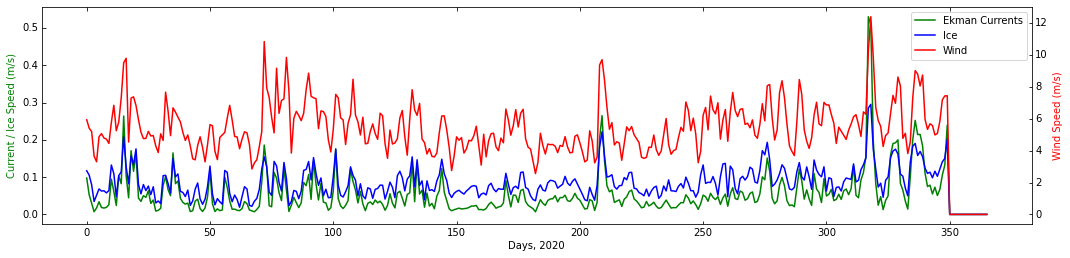

In [28]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt


days = np.arange(len(ice_2020))


f = plt.figure(figsize=(22,4))

host = host_subplot(111, axes_class=axisartist.Axes,figure=f)
plt.subplots_adjust(right=0.75)

#par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right")#, offset=(60, 0))

#par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

p1, = host.plot(days, ek_2020, label="Ekman Currents", c='g')
#p4, = host.plot(days, geo_2020, label = 'Geostrophic Currents', c='b')
p2, = host.plot(days, ice_2020, label="Ice", c='b')
p3, = par2.plot(days, wind_2020, label="Wind", c='r')

host.set_xlabel("Days, 2020")
host.set_ylabel("Current / Ice Speed (m/s)")
#par1.set_ylabel("Ice Speed (m/s)")
par2.set_ylabel("Wind Speed (m/s)")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
#par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.show()

#f.savefig('IceGovernor2020.pdf',dpu = 250)

In [29]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
days = np.arange(len(ice_2020))

/var/folders/sb/pj02x12513n3f5nrsb0psm9w0000gn/T/ipykernel_63272/2037225580.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpu" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Ice-OceanvsPumping2020.pdf',dpu = 250)


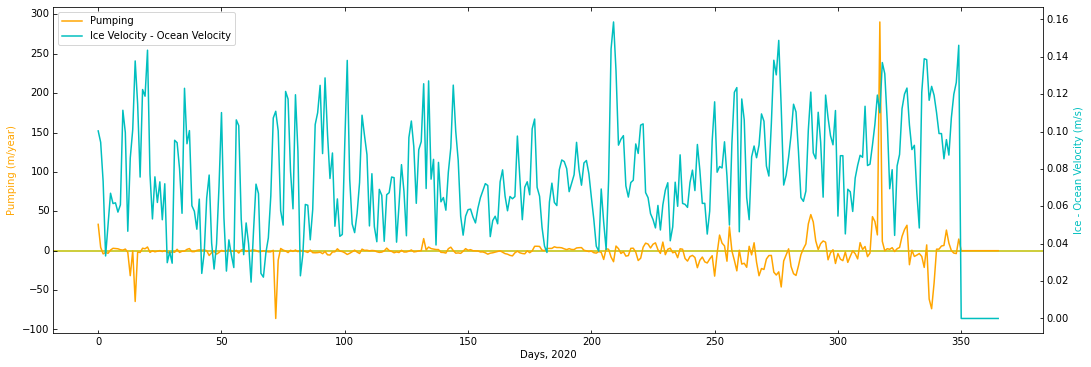

In [31]:
f = plt.figure(figsize=(22,6))

par5 = host_subplot(111, axes_class=axisartist.Axes,figure=f)
plt.subplots_adjust(right=0.75)
par5.axhline(y=0, xmin=0, xmax=1,c='y')

par6 = par5.twinx()
par6.axis["right"].toggle(all=True)
#par6.axhline(y=0, xmin=0, xmax=1)

#par7 = par5.twinx()
#par7.axis["right"].toggle(all=True)

p5, = par5.plot(days, pump_2020, label="Pumping", c='orange')
p6, = par6.plot(days, diff_2020, label="Ice Velocity - Ocean Velocity", c='c')
#p7, = par7.plot(days, ek_2020, label="Ekman currents", c = 'b')
#p7, = par6.plot(days, ice_2020, label="Ice Speed", c='b')

par5.set_xlabel("Days, 2020")
par5.set_ylabel("Pumping (m/year)")
par6.set_ylabel("Ice - Ocean Velocity (m/s)")

par5.legend()

par5.axis["left"].label.set_color(p5.get_color())
par6.axis["right"].label.set_color(p6.get_color())

#par5.axvline(x=72, ymin=0, ymax=1,c='r')

#f.savefig('Ice-OceanvsPumping2020.pdf',dpu = 250)

In [ ]:
pump_2020[317] #13 nov

In [ ]:
pump_2020[72] #12 mar

In [ ]:
pump_2020[338]

In [ ]:

d = dt.datetime(2020,3,12) #runs through days of the month

### ALL THE VARIABLES
#ice drift
up,vp = DRIFT.get_vels([d]) #native grid
upp,vpp = GPathfinder2GPathfinder.rg_vecs(up,vp) #Pathfinder grid
upr,vpr = GPathfinder2Gplot.rg_vecs(upp,vpp)
    
#ice concentration
a = IC.get_aice([d],verbos=True) #native grid
alpha = GIC2GPathfinder.rg_array(a[0]) #Pathfinder grid
    
#winds
Wind.get_dates(d) 
uw,vw = Wind.get_vels()
uwp,vwp = GE2GPathfinder.rg_vecs(uw,vw) #regridded to Pathfinder
    
#geostrophic currents
ug,vg = GEO.get_vels_daily([d],verbos=False)
ugp,vgp = GCPOM2GPathfinder.rg_vecs(ug,vg) #regridded to Pathfinder
ugr,vgr = GPathfinder2Gplot.rg_vecs(ugp,vgp)
    
###CALCULATING EKMAN 
ue, poo, tau_all, poo, poo, poo, poo = CP.current(uwp,vwp,upp,vpp,ugp,vgp,alpha)
pump = CP.weighted_pump(tau_all)
uer,ver = GPathfinder2Gplot.rg_vecs(ue[:,:,0],ue[:,:,1])

##ocean speed
uocean = ue[:,:,0] + ugp
vocean = ue[:,:,1] + vgp
uor,vor = GPathfinder2Gplot.rg_vecs(uocean,vocean)


    
###CALCULATING SPEEDS
for n in range (len(GPathfinder.xpts)):
    for m in range (len(GPathfinder.ypts)): #anywhere on BG grid 
            
        if n in range(xmin,xmax) and m in range(ymin,ymax):
            ek_speed[n,m] = np.hypot(ue[n,m,0],ue[n,m,1])
            ice_speed[n,m] = np.hypot(upp[n,m],vpp[n,m])
            wind_speed[n,m] = np.hypot(uwp[n,m],vwp[n,m])
            geo_speed[n,m] = np.hypot(ugp[n,m],vgp[n,m])
            uocn[n,m] = ue[n,m,0] + ugp[n,m] #ocean speed = Ekman + geostrophic
            vocn[n,m] = ue[n,m,1] + vgp[n,m]
            ocn_speed[n,m] = np.hypot(uocn[n,m],vocn[n,m])
            ek_pump[n,m] = pump[n,m]
            dot[n,m] = uocn[n,m]*upp[n,m] + vocn[n,m]*vpp[n,m] #dot product between ocean speed and ice speed 
                                                        #(component of ocean speed projected along ice direction)
            diff[n,m] = ice_speed[n,m] - dot[n,m] #ice speed - ocean speed 
                
                
        else:
            ek_speed[n,m] = np.nan
            ice_speed[n,m] = np.nan
            wind_speed[n,m] = np.nan
            geo_speed[n,m] = np.nan
            ek_pump[n,m] = np.nan
            uocn[n,m] = np.nan
            vocn[n,m] = np.nan
            ocn_speed[n,m] = np.nan
            dot[n,m] = np.nan
            diff[n,m] = np.nan

In [ ]:
m = ccrs.NorthPolarStereo()
f = plt.figure(figsize=(18,12))



ax = plt.subplot(2,3,1,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ue[:,:,0],ue[:,:,1]))
ax.quiver(Gplot.xpts,Gplot.ypts,uer,ver) 
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('Ekman Currents')


ax = plt.subplot(2,3,4,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ek_speed,cmap='coolwarm')
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('Ekman Speed')


ax = plt.subplot(2,3,6,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,ek_pump,cmap='coolwarm')#,vmin=-10,vmax=10)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("Pumping")

ax = plt.subplot(2,3,3,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(ugp,vgp))
ax.quiver(Gplot.xpts,Gplot.ypts,ugr,vgr) 
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('Geostrophic Currents')

#ax = plt.subplot(2,3,3,projection=m)
#ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
#s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(uocean,vocean))
#ax.quiver(Gplot.xpts,Gplot.ypts,uor,vor) 
#ax.add_feature(cfeature.COASTLINE)
#plt.colorbar(s)
#plt.title('Ocean Currents')

ax = plt.subplot(2,3,5,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.pcolormesh(GPathfinder.xpts,GPathfinder.ypts,diff,cmap='coolwarm')
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title("Ice - Ocean Speed")


ax = plt.subplot(2,3,2,projection=m)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
s = ax.contourf(GPathfinder.xpts,GPathfinder.ypts,np.hypot(upp,vpp))
ax.quiver(Gplot.xpts,Gplot.ypts,upr,vpr) 
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s)
plt.title('Ice Motion')

#f.savefig('12Mar2020.pdf',dpu = 250)